# BVM Hands-On Tutorial (Part 1/2)

---

In this tutorial we will set up the foundations to load and augment data, create a fully-convolutional network for image segmentation, and train it to solve multi-class segmentation problems in medical application.

**Before we begin:** 

Please log in into your Google Drive and go to https://drive.google.com/drive/folders/1HqEgzS8BV2c7xYNrZdEAnrHk7osJJ--2 to find the file `Task02_Heart.tar` of the Medical Segmentation Decathlon challenge. Right click the file and add a copy in your Google Drive.


The dataset consists of mono-modal MR images of the heart plus its left atrium segmentation masks.

Let's get started with the code. Add all imports and some helper functions for visualisation:

In [0]:
%%capture
import warnings
warnings.filterwarnings("ignore")

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from tqdm import tqdm_notebook as tqdm

from google.colab import drive
import tarfile

!git clone https://github.com/multimodallearning/bvm_tutorial.git
from bvm_tutorial.utils import init_weights, dice_coeff, visualise_sample_part1
from bvm_tutorial.transforms import ZeroPad, Crop, Scale, AugmentAffine, ToCuda

Now mount your Google Drive in colab. You will be asked to initially grant access to your drive from colab.

In [0]:
drive.mount('/content/drive')

If run for the first time, we need to extract the single files from `Task02_Heart.tar` on the Google Drive:

In [0]:
tar = tarfile.open(name='/content/drive/My Drive/Task02_Heart.tar', mode='r')
tar.extractall()
tar.close()

---

Now that we have some data, we can use PyTorch utility classes to load the training case files into batches of tensors.

PyTorch provides us with the following classes:

1.   Dataset - Specify how to load a data entity (item[0]=file1.nii.gz, item[1]=file3.nii.gz, ...)
2.   Datasampler - Specify a sampling strategy (sequential, random, subsets, ...)
3.   Dataloader - Batch up the samples for training

In our custom dataset we can define from where to load the files, and how to convert them into torch tensors:

In [0]:
class MSD02HeartDataset(Dataset):
  """Dataset MSD Task_02 Heart: Data access on GDrive and conversion to torch"""

  def __init__(self, transforms=[]):
    # Only ids with ground truth data
    self.ids = [3, 4, 5, 7, 9, 10, 11, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 29, 30]
    self.pad0 = [0, 10, 5, 0, 15, 5, 5, 5, 20, 5, 4, 15, 10, 15, 10, 10, 5, 5, 11, 10]
    self.pad1 = [0, 10, 5, 0, 15, 5, 5, 5, 20, 5, 4, 15, 10, 15, 10, 10, 5, 5, 10, 10]

    self._transforms = Compose(transforms)

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, item):
    assert 0 <= item < len(self.ids), 'Data index not in valid range.'
    
    result = {'pad0': self.pad0[item],
              'pad1': self.pad1[item],
              'id': self.ids[item]}

    item = self.ids[item]

    fn_image = '/content/Task02_Heart/imagesTr/la_{:03}.nii.gz'.format(item)
    fn_label = '/content/Task02_Heart/labelsTr/la_{:03}.nii.gz'.format(item)

    result['image'] = nib.load(fn_image).get_data()[:, :, :, np.newaxis]
    result['label'] = nib.load(fn_label).get_data()[:, :, :, np.newaxis]

    # Numpy order: x, y, z, c
    result['image'] = torch.from_numpy(result['image']).float()
    result['label'] = torch.from_numpy(result['label']).long()

    # Torch order: c, z ,y ,x
    result['image'] = result['image'].permute(3, 2, 1, 0)
    result['label'] = result['label'].permute(3, 2, 1, 0)

    # Pytorch works on 5D tensors for spatial data
    result['image'] = result['image'].unsqueeze(0)  # b, c, z, y, x
    result['label'] = result['label'].unsqueeze(0)
    result = self._transforms(result)
    result['image'] = result['image'].squeeze(0)  # c, z, y, x
    result['label'] = result['label'].squeeze(0)

    return result  # batch dimension will be added later with the dataloader

As you can see, our dataset constructor expects a list of "transforms".

We have already imported some pre-defined transformations for pre-processing and augmentating the Heart dataset, to bring the different sized images into a common voxel size, downscale them for less computational resource demand, and provide sample affine augmentation via the grid sampler.

Finally, after definition we need to instantiate the data loading classes.

During this, we create a training and a validation set in a split of 80% vs. 20%:

In [5]:
z_slice = 23    # z slice that shall be plotted later
batch_size = 4  # number of samples per batch

augmentation_training = [ZeroPad(),
                         Crop(60, -60, 0, 320, 0, 160),  # ROI
                         Scale(.3, .3, .3),
                         AugmentAffine(0.1),
                         ToCuda()]
augmentation_validate = [ZeroPad(),
                         Crop(60, -60, 0, 320, 0, 160),  # ROI
                         Scale(.3, .3, .3),               
                         ToCuda()]

dataset_training = MSD02HeartDataset(transforms=augmentation_training)
dataset_validate = MSD02HeartDataset(transforms=augmentation_validate)

indices = list(range(len(dataset_training)))  # don't take dataset_training.ids!
split_index = int(len(dataset_training) * 0.8)  # data split 80:20 (training:validation)

sampler_training = SubsetRandomSampler(indices[:split_index])
sampler_validate = SubsetRandomSampler(indices[split_index:])

loader_training = DataLoader(dataset=dataset_training,
                             batch_size=batch_size,
                             sampler=sampler_training,
                             drop_last=True)

loader_validate = DataLoader(dataset=dataset_validate,
                             batch_size=batch_size,
                             sampler=sampler_validate,
                             drop_last=True)

print('Indices training:', sampler_training.indices)
print('Indices validation:', sampler_validate.indices)

Indices training: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Indices validation: [16, 17, 18, 19]


So, how does a batch look like?

In [6]:
# Print training batch sample sizes
print('Batch size of', batch_size, 'gives you the following batches per epoch:')
for idx, sample in enumerate(loader_training):
  print('Mini-batch', idx, 'of size', sample['image'].size())

Batch size of 4 gives you the following batches per epoch:
Mini-batch 0 of size torch.Size([4, 1, 48, 96, 60])
Mini-batch 1 of size torch.Size([4, 1, 48, 96, 60])
Mini-batch 2 of size torch.Size([4, 1, 48, 96, 60])
Mini-batch 3 of size torch.Size([4, 1, 48, 96, 60])


Set up a plot for visualisation:

In [0]:
%%capture
# Visualisation of the training every 5 epochs in a comprehensive plot:
n_epochs = 21
every_epoch = 5
fig, axs = plt.subplots(n_epochs//every_epoch + 1, 4, sharex=True, sharey=True,
                        figsize=(4*4, 5*n_epochs//every_epoch))

---


**Task 1**: Define a simple Fully-Connected Network (FCN) architecture:

✔ Use double 3x3 convolutional blocks, such as in `block0`

✔ 2 poolings, and 1 final upsampling

✔ Double the channel number, half the spatial resolution

✔ To keep it easy: Use padding, so size of feature map after convolution is same as before



In [0]:
'''
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.block0 = nn.Sequential(nn.BatchNorm3d(1),
                                nn.Conv3d(1, 15, 3, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(15),
                                nn.Conv3d(15, 15, 3, padding=1),
                                nn.ReLU()
                               )
    
    # self.max_p0 = ...
    # self.block1 = ...
    # ...
    # self.block3 = 
    
  def forward(self, inputs, encoder_only=False):
    output0 = self.block0(inputs)
    # pool0 = ...
    # output1 = ...
    # ...
    # output_final = ...
    # return F.interpolate(output_final, scale_factor=?)
'''

In [0]:
# Full network for debug

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.block0 = nn.Sequential(nn.BatchNorm3d(1),
                                nn.Conv3d(1, 15, 3, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(15),
                                nn.Conv3d(15, 15, 3, padding=1),
                                nn.ReLU()
                               )
                    
    self.mp01 = nn.MaxPool3d(2, 2)
                    
    self.block1 = nn.Sequential(nn.BatchNorm3d(15),
                                nn.Conv3d(15, 30, 3, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(30),
                                nn.Conv3d(30, 30, 3, padding=1),
                                nn.ReLU()
                               )
                    
    self.mp12 = nn.MaxPool3d(2, 2)
                    
    self.block2 = nn.Sequential(nn.BatchNorm3d(30),
                                nn.Conv3d(30, 90, 3, padding=1),
                                nn.ReLU(),                    
                                nn.BatchNorm3d(90),
                                nn.Conv3d(90, 90, 3, padding=1),
                                nn.ReLU()
                               )
                    
    self.block3 = nn.Sequential(nn.BatchNorm3d(120),
                                nn.Conv3d(120, 90, 3, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(90),
                                nn.Conv3d(90, 60, 3, padding=1),
                                nn.ReLU()
                               )
                    
    self.block4 = nn.Sequential(nn.BatchNorm3d(75),
                                nn.Conv3d(75, 60, 3, padding=1),
                                nn.ReLU(),
                                nn.BatchNorm3d(60),
                                nn.Conv3d(60, 30, 3, padding=1),
                                nn.ReLU()
                               )
                    
    self.block5 = nn.Sequential(nn.Conv3d(30, 15, 1),
                                nn.ReLU(),
                                nn.Conv3d(15, 1, 1)
                               )
    
  def forward(self, inputs):
    output0 = self.block0(inputs)
    output1 = self.mp01(output0)
    output1 = self.block1(output1)
    output2 = self.mp12(output1)
    output2 = self.block2(output2)

    output3 = F.interpolate(output2, scale_factor=2)
    output3 = self.block3(torch.cat([output3, output1], dim=1))
    output4 = F.interpolate(output3, scale_factor=2)
    output4 = self.block4(torch.cat([output4, output0], dim=1))
    
    return self.block5(output4)

Let's set up the experiment.

First, we need the network model (`net`). The network weights need to be initialized with weights near 1 to avoid vanishing/exploding gradients issues that can later slow down the learning process.

Training of neural networks is an optimsation process. Thus, we further need:

1.  Parameters of a model to be optimized: ```net.parameters()```
2.  Optimization criterion: ```nn.BCELoss``` (binary cross-entropy)
3.  Optimizer adapting parameters of (1.) in order to minimize loss (2.): ```torch.optim.Adam``` (https://arxiv.org/pdf/1412.6980.pdf)

One hyper-parameter of such gradient-descent optimisation is the number of iterations:

1.  Number of epochs: ```n_epochs``` (one epoch: processing all training sample batches once)
2.  For an unbalanced dataset it's also recommended, if the loss of classes re-weighted

After the set up, we just run the main training routine and watch the loss going down!

In [11]:
# Network initialisation
net = Net().cuda()
net.apply(init_weights)

# Hyper-parameters
n_epochs = 21
target_weight = torch.tensor([50.]).cuda()  # unbalanced data: BG 50x overrepresented

# Set up optimisation for training process
criterion = nn.BCEWithLogitsLoss(pos_weight=target_weight)  # includes sigmoid()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=(9*n_epochs)//10, gamma=0.1)

# Save loss of each epoch
losses_training = []
losses_validate = []

progress = tqdm(range(n_epochs), desc='progress')

######################
# MAIN TRAINING LOOP #
######################

for epoch in progress:
  
  # Scheduler will adapt the learning rate once the step count reaches threshold
  scheduler.step()  
  
  
  ########################################
  #               TRAINING               #
  ########################################

  sum_loss = 0
  
  # Parameters must be trainable
  net.train(True)
  with torch.set_grad_enabled(True):
    
    # main loop to process all training samples (packed into batches)
    for sample in loader_training:
      
      result = net(sample['image'])  # forward run

      loss = criterion(result, sample['label'].float())  # compute BCE loss

      optimizer.zero_grad()
      loss.backward()   # update gradients according to loss
      optimizer.step()  # update net weights (parameters) according to grads

      sum_loss += loss.item()
  
  losses_training.append(sum_loss / len(loader_training))

  if epoch % 5 == 0:
    axs = visualise_sample_part1(axs, sample, result, True, epoch, 5, z_slice)
  
  
  ########################################
  #              VALIDATION              #
  ########################################

  sum_loss = 0
  
  # Parameters must not be trainable
  net.train(False)
  with torch.set_grad_enabled(False):
    
    # main loop to process all validation samples (packed into batches)
    for sample in loader_validate:
      result = net(sample['image'])  # forward run

      loss = criterion(result, sample['label'].float())  # compute BCE loss

      # No need to backpropagate here!
      
      sum_loss += loss.item()
  
  losses_validate.append(sum_loss / len(loader_validate))
  
  if epoch % 5 == 0:
    sample['label'] = sample['label']
    axs = visualise_sample_part1(axs, sample, result, False, epoch, 5, z_slice)
  
  progress.set_postfix(loss=losses_training[-1], val_loss=losses_validate[-1])

Let's first check if training has converged. We plot the loss over all training epochs.

Thus, we compare the training and validation loss curves:

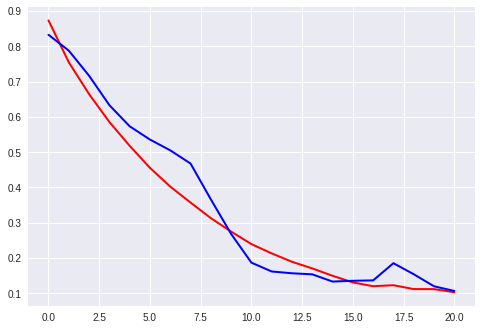

In [13]:
plt.plot(losses_training, 'r-', linewidth=2)  # training loss in red
plt.plot(losses_validate, 'b-', linewidth=2)  # validation loss in blue

Reaching a plateau means, we can hopefully roughly see the segmentation matching the ground truth mask.

The following plot rows have been generated every fifth epoch:

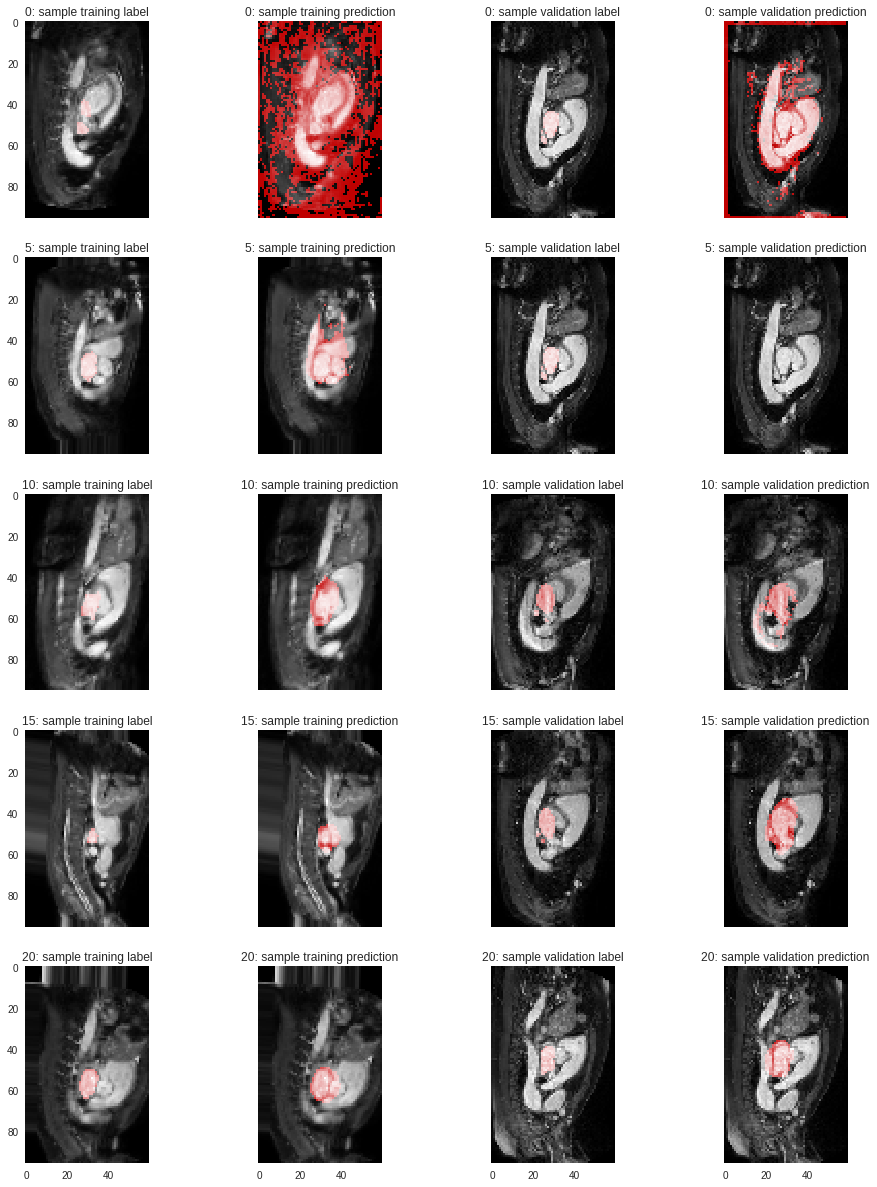

In [12]:
fig

---

**Task 2**: Extend FCN to U-Net (Symmetric decoder, more upsamplings, skip connections)

Go up to the [network definition](https://colab.research.google.com/drive/1APog6LaQpSMCDFG-eXhSKiFxMfjYN_7h?authuser=1#scrollTo=ZtuaD78Yda2y&line=4&uniqifier=1) and extend the network by adding a symmetric decoder path (interspersed with upsamplings) and add skip connections from left to right, by using `torch.cat()`